In [1]:
import pickle
from IPython.display import clear_output

import sys;import os;
module_path = os.path.abspath(os.path.join('..')).split('PythonCode')[0]+'PythonCode'
if module_path not in sys.path: sys.path.append(module_path+"/")

import Plib.DataFarm.Kibot as datafarm
import Plib.Backtester.Backtrader as bt
import Plib.Signals.TAnalysis as signalsfarm
import Plib.Utils.Tools as tls

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

/Users/rob/opt/intelpython/latest/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 88 from PyObject
  return f(*args, **kwds)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### SMA Crossover Strategy Example

In [ ]:
import Plib.Strategies.SMACrossover as s

In [2]:
ret=s.SMACrossoverBT.testStrategy(stock='MSFT', pkl=False, fname='./data/SMACrossover.pickle')

Initial Positions: 2500.0
Final Positions: 2212.68
Countervalue (increase/decrease %): 2212.68 (-11.4929%)  
Commissions (CUR): 0.43  Slippage: 0.06


### Application to multiple securities

In [12]:
ret=s.SMACrossoverBT.testStrategy2(stocks=['GS','AMZN','MSFT','AAPL'], pkl=False, fname='./data/SMACrossover.pickle')
ret[0]

GS                       AMZN  \
Str. Rets                        0.000000                   0.000000   
Mkt Rets                        -0.385048                  -0.385048   
Avg Daily Rets                   0.000000                   0.000000   
Avd Daily Vol                    0.000000                   0.000000   
Ann.ed Returns                   0.000000                   0.000000   
Ann.ed Vol                       0.000000                   0.000000   
Sharpe Ratio     74326777510272816.000000   74326777510272816.000000   
t-stat          136907768253831040.000000  136907768253831040.000000   
Pvalue                           0.000000                   0.000000   
Adj Pvalue                       0.000000                   0.000000   
Sortino Ratio                         inf                        inf   
Omega Ratio                          -inf                       -inf   
Inform. Ratio                    0.663391                   0.663391   
Skewness                         0.000000                   0.000000   
Kurtosis                         0.000000                   0.000000   
30d HVaR95                       0.000000                   0.000000   
30d adj VaR95                    0.000000                   0.000000   
MDD Duration                     0.000000                   0.000000   
Max Drawdown %                   0.000000                   0.000000   
Profits                       2500.000000                2500.000000   
Geom.Rets %                      0.000000                   0.000000   
Total trades                     0.000000                   0.000000   
Wins %                           0.000000                   0.000000   
Average Win                           NaN                        NaN   
Average Loss                          NaN                        NaN   
Max Win                               NaN                        NaN   
Max Loss                              NaN                        NaN   
Max Cons. Wins                        NaN                        NaN   
Max Cons. Loss                        NaN                        NaN   
Avg Win Durat                         NaN                        NaN   
Avg Loss Durat                        NaN                        NaN   
Payoff (x:1)                          NaN                        NaN   
Profit Factor                    0.000000                   0.000000   
Expectancy                            NaN                        NaN   
Exp.Opp.ty                            NaN                        NaN   
S.Quality                             NaN                        NaN   
Acorr(1)                              NaN                        NaN   
Avg Trade                             NaN                        NaN   
Kelly %                               NaN                        NaN   

                                  MSFT                       AAPL  
Str. Rets                    -0.114917                   0.000000  
Mkt Rets                     -0.385048                  -0.385048  
Avg Daily Rets               -0.000143                   0.000000  
Avd Daily Vol                 0.000004                   0.000000  
Ann.ed Returns               -0.004208                   0.000000  
Ann.ed Vol                    3.278005                   0.000000  
Sharpe Ratio                 -1.067106   74326777510272816.000000  
t-stat                       -1.965578  136907768253831040.000000  
Pvalue                        0.916536                   0.000000  
Adj Pvalue                    1.000000                   0.000000  
Sortino Ratio                -1.070274                        inf  
Omega Ratio                   0.439387                       -inf  
Inform. Ratio                 0.543512                   0.663391  
Skewness                    -21.419968                   0.000000  
Kurtosis                    527.971141                   0.000000  
30d HVaR95                    0.000000                   0.000000  
30

#### Details of Implementation

In [13]:
tickers=['MSFT','SPY']
params=[10,60]
init_params={'freq':'D', 'tz':'America/New_York', 'db':'','in_mem':True,'str_name':'trade',
             'str_desc':'','sdate':'2006-12-28','edate':'2009-04-30',
               'brk':1,'exc':1,'cli':100,'cur':'USD'}
algo_params={'Type':'KELLY','Issue':{'KELLY':0.13,'CURR':2500,'FRAC':0.1,'STYPE':'STK'},'Issues':tickers}
stat_params={'freq':'D','MAR':-0.001,'ConfLev':0.95,'net_comm':False,
             'Leverage':1.25,'log_rets':True,'SnapType':'silent'}

In [14]:
#Setup granularity of data and import series with right timezone
#data={}
#data['0']=datafarm.get_eod_data('MSFT',dt_start,dt_end,tz='America/New_York')
#data['1']=datafarm.get_eod_data('SPY',dt_start,dt_end,tz='America/New_York')
#fname='algo451.pickle'
#with open(fname, 'wb') as handle:
#    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)  
fname='./data/algo451.pickle'
with open(fname, 'rb') as handle:
    data = pickle.load(handle) 

In [15]:
#Prepare data
def setupData(data={},tickers=[],params=[],opt_params={},algo_params={},init_params={}):
    #0 no squaring, 1 squaringAlt, 2 squaringTPSL
    #0 % bracketing, 1 bracketingADR
    #0 random slippage, 1 slippageFixed
    #0 % commissions, 1 commissionsFixed  
    #0 no money mgmt, 1 kelly fraction
    rules={'Squaring':0,'Slippage':0,'Commissions':0,'Bracketing':0,'MoneyMgmt':1}
    b=bt.Buffer(init_params=init_params,rules=rules)    
    #Arguments in params are optimizable
    w1=int(params[0])
    w2=int(params[1])
    df3=signalsfarm.getSMA(data['0'].copy(),'Close',w1,'smaFast').fillna(0)
    df4=signalsfarm.getSMA(df3,'Close',w2,'smaSlow').fillna(0)
    #Slippage, Commission %, TP%, SL%
    sec_params=[0.0015 ,0.001,10,5]
    #Control for strange characters in tickers names
    b.addData(df4, tickers[0], sec_params, init_params['freq'], fix_tz=True, fix_frq=True)
    b.addTracker(data['1'].copy(), tickers[1], init_params['freq'], fix_tz=True, fix_frq=True)
    b.finalizeData(usd_account=2500,params=algo_params)
    return b
b=setupData(data,tickers,params,{},algo_params,init_params)


In [16]:
def logic(i,x,om,mdata, hdata,trade,checkStops,closeAllTrades,moneyMgmt,algo_params):
    issue=algo_params['Issues'][0]
    
    #Obtain market price
    mprice=x['Close_'+issue].iloc[i-1]  
    
    #Obtain best quantity to trade
    qty=moneyMgmt(args={'price':mprice,'kelly':algo_params['Issue']['KELLY'],
          'wealth':algo_params['Issue']['CURR'],
          'fraction':algo_params['Issue']['FRAC'],'qty':1})

    #Close all trades at the end
    if i >= len(x)-1:
        #print('Final squaring')
        closeAllTrades(issue,mprice,i)
    else:
        #Trade with LS-MA Crossover 
        day=1+x['Date'].iloc[i].weekday()
        hour=x['Date'].iloc[i].hour
        #if (day not in (5,6)) and hour in (9,10,11,12,13,14,15,16):  #Since trading on next day, loop from sunday to friday
        if hdata['smaFast_'+issue].iloc[i-1]!=0 and hdata['smaSlow_'+issue].iloc[i-1] !=0:
            if (hdata['smaFast_'+issue].iloc[i] > hdata['smaSlow_'+issue].iloc[i]) and (hdata['smaFast_'+issue].iloc[i-1] < hdata['smaSlow_'+issue].iloc[i-1]):
                if x.Account.iloc[0] > qty*mprice:
                    trade(i,issue,-1,mprice,qty)

            elif (hdata['smaFast_'+issue].iloc[i] > hdata['smaSlow_'+issue].iloc[i]) and (hdata['smaFast_'+issue].iloc[i-1] < hdata['smaSlow_'+issue].iloc[i-1]):
                if x.Account.iloc[0] > qty*mprice:
                    trade(i,issue,1,mprice,qty)



In [19]:
b.run(logic)

Initial Positions: 2500.0
Final Positions: 2212.52
Countervalue (increase/decrease %): 2212.52 (-11.499%)  
Commissions (CUR): 0.43  Slippage: 0.07


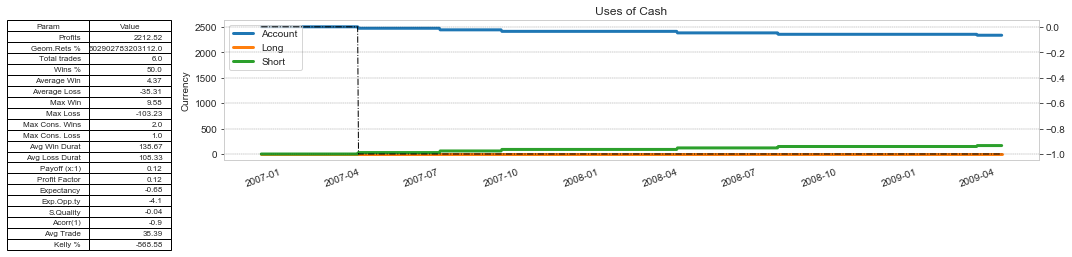

FF-5 Performance Attribution
coefficient of determination: 0.4867
str_excess =  -0.0066  +  -0.1481 mkt_excess +  -0.1232 SMB +  0.0753 HML +  -0.397 RMW +  -0.216 CMA


In [20]:
r,ts=b.printSnapshot(type='all',MAR=-0.001,ConfLev=0.95,net_comm=False,log_rets=True)

In [22]:
r[r['MSFT_sh']>0]

Open_MSFT  High_MSFT  Low_MSFT  Close_MSFT  \
Date                                                                    
2007-04-20 00:00:00-04:00      28.69      29.10     28.70       29.02   
2007-07-23 00:00:00-04:00      31.20      31.52     31.12       31.19   
2007-10-02 00:00:00-04:00      29.77      29.85     29.57       29.70   
2008-04-21 00:00:00-04:00      30.20      30.60     30.12       30.42   
2008-08-15 00:00:00-04:00      27.98      28.15     27.58       27.81   
2009-04-01 00:00:00-04:00      18.29      19.36     18.18       19.31   
2009-04-30 00:00:00-04:00      20.60      21.10     20.01       20.26   

                           Adjusted_close_MSFT  Volume_MSFT  smaFast_MSFT  \
Date                                                                        
2007-04-20 00:00:00-04:00                29.02     61625864      28.61200   
2007-07-23 00:00:00-04:00                31.19     48910516      30.42999   
2007-10-02 00:00:00-04:00                29.70     33705822      29.23000   
2008-04-21 00:00:00-04:00                30.42     54411698      28.99300   
2008-08-15 00:00:00-04:00                27.81     47268995      27.36800   
2009-04-01 00:00:00-04:00                19.31     96438844      18.04600   
2009-04-30 00:00:00-04:00                20.26     87439809      19.62300   

                           smaSlow_MSFT                      Date  Traded  \
Date                                                                        
2007-04-20 00:00:00-04:00     28.593832 2007-04-20 00:00:00-04:00    -1.0   
2007-07-23 00:00:00-04:00     30.371457 2007-07-23 00:00:00-04:00    -1.0   
2007-10-02 00:00:00-04:00     29.208252 2007-10-02 00:00:00-04:00    -1.0   
2008-04-21 00:00:00-04:00     28.922325 2008-04-21 00:00:00-04:00    -1.0   
2008-08-15 00:00:00-04:00     27.152667 2008-08-15 00:00:00-04:00    -1.0   
2009-04-01 00:00:00-04:00     17.886333 2009-04-01 00:00:00-04:00    -1.0   
2009-04-30 00:00:00-04:00     18.144167 2009-04-30 00:00:00-04:00     1.0   

                           ...  MSFT_sp  MSFT_prt  MSFT_last  MSFT_signal  \
Date                       ...                                              
2007-04-20 00:00:00-04:00  ...   0.0000      -1.0       -1.0         -1.0   
2007-07-23 00:00:00-04:00  ...   0.0000      -2.0       -1.0         -1.0   
2007-10-02 00:00:00-04:00  ...   0.0000      -3.0       -1.0         -1.0   
2008-04-21 00:00:00-04:00  ...   0.0000      -4.0       -1.0         -1.0   
2008-08-15 00:00:00-04:00  ...   0.0279      -5.0       -1.0         -1.0   
2009-04-01 00:00:00-04:00  ...   0.0184      -6.0       -1.0         -1.0   
2009-04-30 00:00:00-04:00  ...   0.0202       0.0        1.0          1.0   

                            MSFT_TP    MSFT_SL  MSFT_OT  MSFT_CK  Position  \
Date                                                                         
2007-04-20 00:00:00-04:00  25.82100  30.124500      0.0      0.0      -1.0   
2007-07-23 00:00:00-04:00  28.04400  32.718000      0.0      0.0      -1.0   
2007-10-02 00:00:00-04:00  26.79309  31.258605      0.0      0.0      -1.0   
2008-04-21 00:00:00-04:00  27.00000  31.500000      0.0      0.0      -1.0   
2008-08-15 00:00:00-04:00  25.09389  29.276205      0.0      0.0      -1.0   
2009-04-01 00:00:00-04:00  16.51644  19.269180      0.0      0.0      -1.0   
2009-04-30 00:00:00-04:00  22.29722  19.256690      0.0      0.0       1.0   

                            Returns  
Date                                 
2007-04-20 00:00:00-04:00 -0.011542  
2007-07-23 00:00:00-04:00 -0.012689  
2007-10-02 00:00:00-04:00 -0.012275  
2008-04-21 00:00:00-04:00 -0.012524  
2008-08-15 00:00:00-04:00 -0.011782  
2009-04-01 00:00:00-04:00 -0.007831  
2009-04-30 00:00:00-04:00 -0.053512  

[7 rows x 28 columns]

In [21]:
b.trades

sec  wl      perc       usd   pricei   pricef  commpi  commpf   slipi  \
0  MSFT   0  0.082587   -2.4700  28.6900  31.1600  0.0000  0.0000  0.0430   
1  MSFT   1 -0.045631    1.3899  31.1600  29.7701  0.0000  0.0000  0.0467   
2  MSFT   0  0.007693   -0.2299  29.7701  30.0000  0.0000  0.0000  0.0447   
3  MSFT   1 -0.074214    2.1458  30.0000  27.8821  0.0000  0.0279  0.0450   
4  MSFT   1 -0.418270    9.5768  27.8821  18.3516  0.0279  0.0184  0.0418   
5  MSFT   0  1.892032 -103.2310  18.3516  20.2702  0.0184  0.0202  0.0275   

    slipf  side                    tstart                      tend  QtyI  \
0  0.0467  -1.0 2007-04-20 00:00:00-04:00 2007-07-23 00:00:00-04:00   1.0   
1  0.0447  -1.0 2007-07-23 00:00:00-04:00 2007-10-02 00:00:00-04:00   1.0   
2  0.0450  -1.0 2007-10-02 00:00:00-04:00 2008-04-21 00:00:00-04:00   1.0   
3  0.0418  -1.0 2008-04-21 00:00:00-04:00 2008-08-15 00:00:00-04:00   1.0   
4  0.0275  -1.0 2008-08-15 00:00:00-04:00 2009-04-01 00:00:00-04:00   1.0   
5  0.1824  -1.0 2009-04-01 00:00:00-04:00 2009-04-30 00:00:00-04:00   1.0   

   QtyF  duration  
0   1.0      94.0  
1   1.0      71.0  
2   1.0     202.0  
3   1.0     116.0  
4   1.0     229.0  
5   6.0      29.0

### Analytics

In [10]:
d1,d2=b.rollingWindowAnalysis(r,log_rets=True)
d1

1 Month                  3 Months  \
Str. Rets                       0.000000                  0.000000   
Mkt Rets                        0.021113                  0.074566   
Avg Daily Rets                  0.000000                  0.000000   
Avd Daily Vol                   0.000000                  0.000000   
Ann.ed Returns                  0.000000                  0.000000   
Ann.ed Vol                      0.000000                  0.000000   
Sharpe Ratio    73120271901898080.000000  73955959285788720.000000   
t-stat          25228890664624164.000000  44197139184572144.000000   
Pvalue                               NaN                       NaN   
Adj Pvalue                           NaN                       NaN   
Sortino Ratio                        inf                       inf   
Omega Ratio                         -inf                      -inf   
Inform. Ratio                  -2.276861                 -1.184899   
Skewness                        0.000000                  0.000000   
Kurtosis                        0.000000                  0.000000   
30d HVaR95                      0.000000                  0.000000   
30d adj VaR95                   0.000000                  0.000000   
MDD Duration                    0.000000                  0.000000   
Max Drawdown %                  0.000000                  0.000000   

                  6 Months   12 Months   24 Months   36 Months   48 Months  \
Str. Rets        -0.011465   -0.035837   -0.058989   -0.114930   -0.114930   
Mkt Rets          0.024855   -0.089606   -0.382714   -0.382714   -0.382714   
Avg Daily Rets   -0.000064   -0.000100   -0.000083   -0.000143   -0.000143   
Avd Daily Vol     0.000001    0.000001    0.000001    0.000004    0.000004   
Ann.ed Returns   -0.008968   -0.006903   -0.002875   -0.004219   -0.004219   
Ann.ed Vol        1.364336    1.747282    1.594240    3.280061    3.280061   
Sharpe Ratio     -1.109920   -1.384789   -1.253813   -1.067850   -1.067850   
t-stat           -0.938054   -1.666594   -2.133998   -1.965799   -1.965799   
Pvalue                 NaN    0.745981    0.913344    0.916459    0.916459   
Adj Pvalue             NaN    1.000000    1.000000    1.000000    1.000000   
Sortino Ratio    -1.116121   -1.392415   -1.258986   -1.071025   -1.071025   
Omega Ratio       0.983737    0.628407    0.755419    0.438817    0.438817   
Inform. Ratio    -0.402527    0.238130    0.617710    0.555362    0.555362   
Skewness        -13.416408  -10.964603  -12.006913  -21.405860  -21.405860   
Kurtosis        180.000000  119.061954  142.746184  527.290750  527.290750   
30d HVaR95        0.000000    0.000000    0.000000    0.000000    0.000000   
30d adj VaR95     0.000000    0.000000    0.000000    0.000000    0.000000   
MDD Duration    111.958333  276.958333  594.958333  852.958333  852.958333   
Max Drawdown %   -1.146452   -3.583656   -5.898940  -11.493004  -11.493004   

                 60 Months  
Str. Rets        -0.114930  
Mkt Rets         -0.382714  
Avg Daily Rets   -0.000143  
Avd Daily Vol     0.000004  
Ann.ed Returns   -0.004219  
Ann.ed Vol        3.280061  
Sharpe Ratio     -1.067850  
t-stat           -1.965799  
Pvalue            0.916459  
Adj Pvalue        1.000000  
Sortino Ratio    -1.071025  
Omega Ratio       0.438817  
Inform. Ratio     0.555362  
Skewness        -21.405860  
Kurtosis        527.290750  
30d HVaR95        0.000000  
30d adj VaR95     0.000000  
MDD Duration    852.958333  
Max Drawdown %  -11.493004

In [11]:
d2

1 Month  3 Months  6 Months     12 Months   24 Months  \
Parameters                                                              
Geom.Rets %         0.0       0.0       0.0  54356.207180  -95.889032   
Wins %              0.0       0.0       0.0     50.000000   50.000000   
Average Win         NaN       NaN       NaN      1.389900    1.767850   
Average Loss        NaN       NaN       NaN     -2.470000   -1.349950   
Max Win             NaN       NaN       NaN      1.389900    2.145800   
Max Loss            NaN       NaN       NaN     -2.470000   -2.470000   
Max Cons. Wins      NaN       NaN       NaN      1.000000    1.000000   
Max Cons. Loss      NaN       NaN       NaN      1.000000    1.000000   
Avg Win Durat       NaN       NaN       NaN     71.000000   93.500000   
Avg Loss Durat      NaN       NaN       NaN     94.000000  148.000000   
Payoff (x:1)        NaN       NaN       NaN      0.560000    1.310000   
Profit Factor       0.0       0.0       0.0      0.562713    1.309567   
Expectancy          NaN       NaN       NaN     -0.110266   -0.124613   
Exp.Opp.ty          NaN       NaN       NaN     -0.220533   -0.498453   
S.Quality           NaN       NaN       NaN     -0.057134   -0.122020   
Acorr(1)            NaN       NaN       NaN           NaN   -0.595609   
Avg Trade           NaN       NaN       NaN     30.187850   29.800450   
Kelly %             NaN       NaN       NaN    -19.668299   -9.514434   

                   36 Months     48 Months     60 Months  
Parameters                                                
Geom.Rets %     6.629987e+14  6.629987e+14  6.629987e+14  
Wins %          5.000000e+01  5.000000e+01  5.000000e+01  
Average Win     4.370833e+00  4.370833e+00  4.370833e+00  
Average Loss   -3.527663e+01 -3.527663e+01 -3.527663e+01  
Max Win         9.576800e+00  9.576800e+00  9.576800e+00  
Max Loss       -1.031300e+02 -1.031300e+02 -1.031300e+02  
Max Cons. Wins  2.000000e+00  2.000000e+00  2.000000e+00  
Max Cons. Loss  1.000000e+00  1.000000e+00  1.000000e+00  
Avg Win Durat   1.386667e+02  1.386667e+02  1.386667e+02  
Avg Loss Durat  1.083333e+02  1.083333e+02  1.083333e+02  
Payoff (x:1)    1.200000e-01  1.200000e-01  1.200000e-01  
Profit Factor   1.239017e-01  1.239017e-01  1.239017e-01  
Expectancy     -6.833854e-01 -6.833854e-01 -6.833854e-01  
Exp.Opp.ty     -4.100312e+00 -4.100312e+00 -4.100312e+00  
S.Quality      -3.879814e-02 -3.879814e-02 -3.879814e-02  
Acorr(1)       -9.026874e-01 -9.026874e-01 -9.026874e-01  
Avg Trade       3.537407e+01  3.537407e+01  3.537407e+01  
Kelly %        -5.689046e+02 -5.689046e+02 -5.689046e+02

In [12]:
#Kelly Fraction Analysis
bt.KellyAnalysis('MSFT',setupData,logic,data,tickers,params,algo_params,stat_params,init_params)


0.05                    0.10  \
Str. Rets                        0.000000               -0.114954   
Mkt Rets                        -0.382714               -0.382714   
Avg Daily Rets                   0.000000               -0.000143   
Avd Daily Vol                    0.000000                0.000004   
Ann.ed Returns                   0.000000               -0.004220   
Ann.ed Vol                       0.000000                3.282316   
Sharpe Ratio     74326726553758080.000000               -1.067356   
t-stat          136827588002002784.000000               -1.964889   
Pvalue                           0.000000                0.916395   
Adj Pvalue                       0.000000                1.000000   
Sortino Ratio                         inf               -1.070527   
Omega Ratio                          -inf                0.438721   
Inform. Ratio                    0.664128                0.555339   
Skewness                         0.000000              -21.420503   
Kurtosis                         0.000000              527.910131   
30d HVaR95                       0.000000                0.000000   
30d adj VaR95                    0.000000                0.000000   
MDD Duration                     0.000000              852.958333   
Max Drawdown %                   0.000000              -11.495360   
Profits                       2500.000000             2212.616000   
Geom.Rets %                      0.000000  614364708795267.625000   
Total trades                     0.000000                6.000000   
Wins %                           0.000000               50.000000   
Average Win                           NaN                4.390700   
Average Loss                          NaN              -35.269500   
Max Win                               NaN                9.576800   
Max Loss                              NaN             -103.231000   
Max Cons. Wins                        NaN                2.000000   
Max Cons. Loss                        NaN                1.000000   
Avg Win Durat                         NaN              138.666667   
Avg Loss Durat                        NaN              108.333333   
Payoff (x:1)                          NaN                0.120000   
Profit Factor                    0.000000                0.124490   
Expectancy                            NaN               -0.682350   
Exp.Opp.ty                            NaN               -4.094098   
S.Quality                             NaN               -0.038691   
Acorr(1)                              NaN               -0.903888   
Avg Trade                             NaN               35.371400   

                                                  0.15  \
Str. Rets                                    -0.130385   
Mkt Rets                                     -0.382714   
Avg Daily Rets                               -0.000164   
Avd Daily Vol                                 0.000006   
Ann.ed Returns                               -0.004827   
Ann.ed Vol                                    3.825979   
Sharpe Ratio                                 -1.051351   
t-stat                                       -1.935425   
Pvalue                                        0.914282   
Adj Pvalue                                    1.000000   
Sortino Ratio                                -1.054382   
Omega Ratio                                   0.383308   
Inform. Ratio                                 0.539027   
Skewness                                    -22.032263   
Kurtosis                                    553.895620   
30d HVaR95                                    0.000000   
30d adj VaR95                                 0.000000   
MDD Duration                                852.958333   
Max Drawdown %                              -13.038540   
Profits                                    2174.036500   
Geom.Rets %     1345520543117144087164922888192.000000   
Total trades                                  6.000000   
Wins %     

In [14]:
###Strategy replay
#%matplotlib notebook
#clear_output(wait=False)
#b.replayStrategy(d,25)
##Then re-set matplotlib
##%matplotlib inline

In [13]:
import pandas as pd
d=r.copy()
period='Y'
df=d[['Traded']].reset_index()
dfb=d[['Returns']].reset_index()

df1=df[df.Traded > 0].groupby(pd.Grouper(key='Date',freq=period)).sum()
df1.columns=['Pos_trades']
df2=df[df.Traded < 0].groupby(pd.Grouper(key='Date',freq=period)).sum()
df2.Traded=abs(df2.Traded)
df2.columns=['Neg_trades']
df3=dfb[dfb.Returns > 0].groupby(pd.Grouper(key='Date',freq=period)).mean()
df3.columns=['Avg Wins %']
df4=dfb[dfb.Returns < 0].groupby(pd.Grouper(key='Date',freq=period)).mean()
df4.columns=['Avg Loss %']
res=df1.join(df2, how='right', rsuffix='r',lsuffix='l')
res['Hit Ratio']=res.Pos_trades/(res.Pos_trades+res.Neg_trades)
if len(df3) >0: res=res.join(df3, how='right', rsuffix='r',lsuffix='l')
if len(df4) >0: res=res.join(df4, how='right', rsuffix='r',lsuffix='l')
hra=res.fillna(0)    
hra

Pos_trades  Neg_trades  Hit Ratio  Avg Loss %
Date                                                                    
2007-12-31 00:00:00-05:00         0.0         3.0        0.0   -0.012161
2008-12-31 00:00:00-05:00         0.0         2.0        0.0   -0.012159
2009-12-31 00:00:00-05:00         1.0         1.0        0.5   -0.030648

### Hit Ratio Analysis

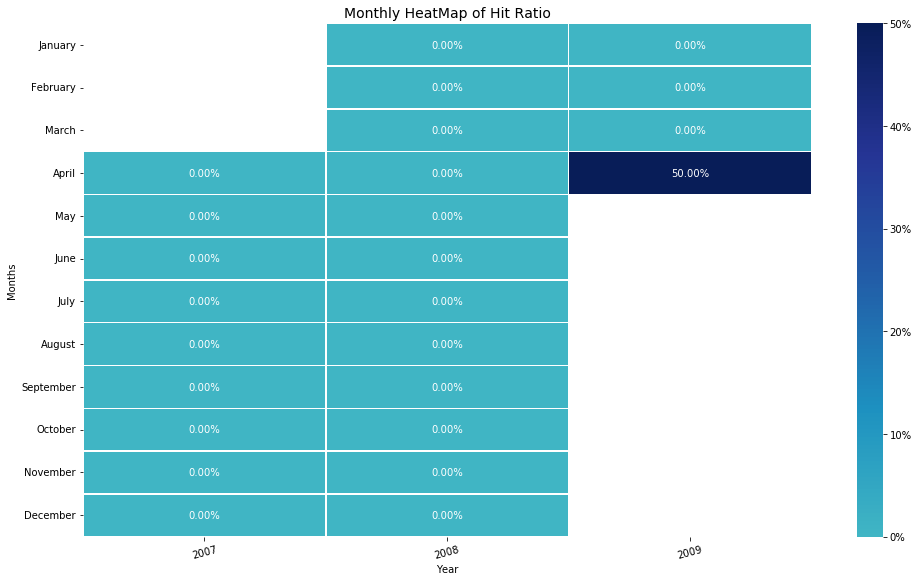

In [14]:
hra=b.hitratioAnalysis(r.copy())
if len(hra)>0:
    for i in range(0,len(tickers)):
        pf=data[str(i)].Close.to_frame()
        b.hitratioAnalysisPlot(hra[0],pf,0.4)

In [15]:
#Plots the shortest sequence of trades producing at least 50 usd
for i in range(0,len(tickers)):
    underlying=data[str(i)].Close.to_frame()
    ret=b.tseqAnalysis(100,3,fs=(18,4),data=underlying)


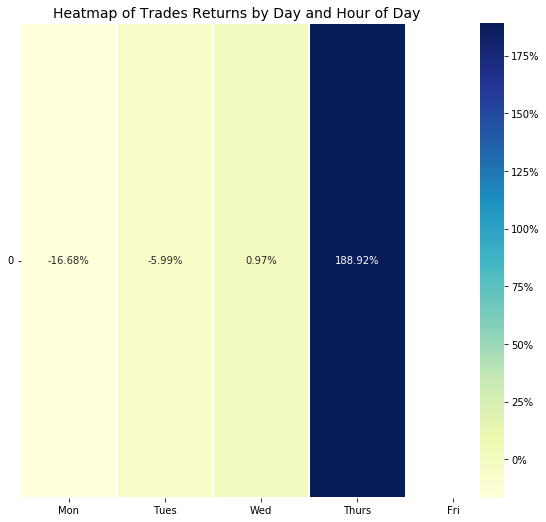

In [16]:
#Look for Trade Filters by hour and week days
tr=b.hwd_filterHeatmap(b.trades.copy())

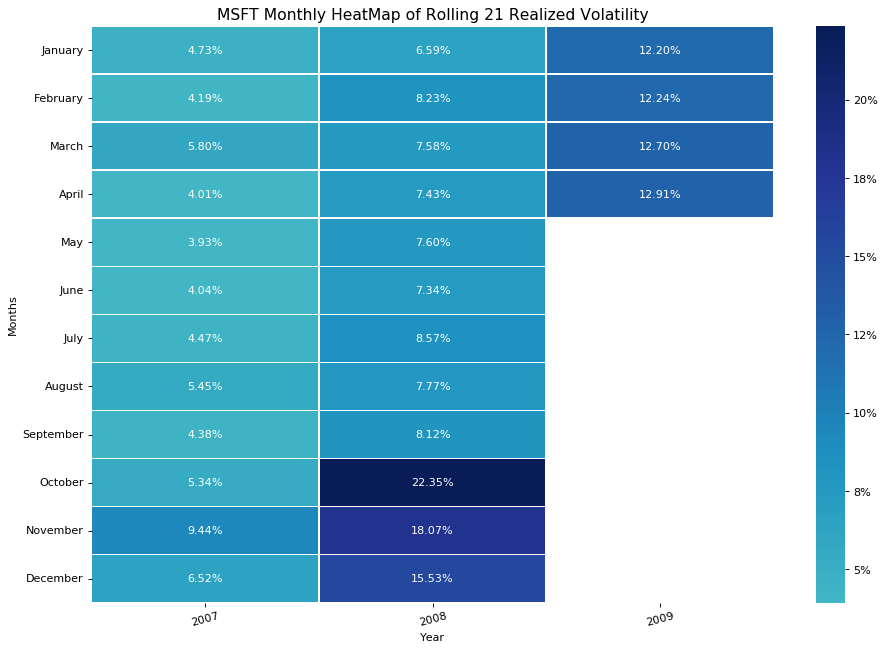

In [17]:
#Rolling 21 Realized Volatility, average by month
for sec in tickers:
    b.volAnalysis(sec,periods=21,fs=(12,8))

### Robustness - Montecarlo Simulation

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


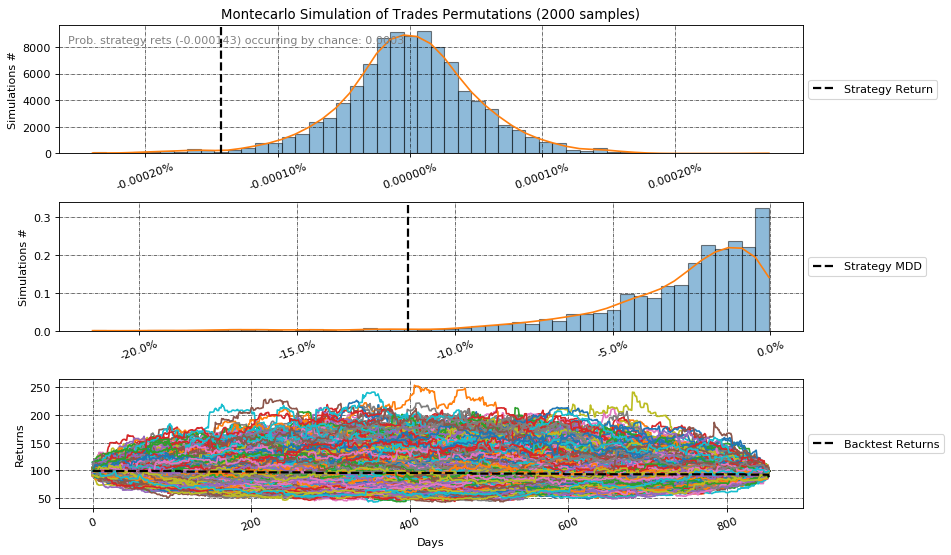

In [18]:
#Robustness Test
mc,mp=b.montecarloAnalysis(r.copy(),'SPY',N=2000,bins=50,log_rets=True)


The 99.0% confidence level is: -0.006% 0.006%


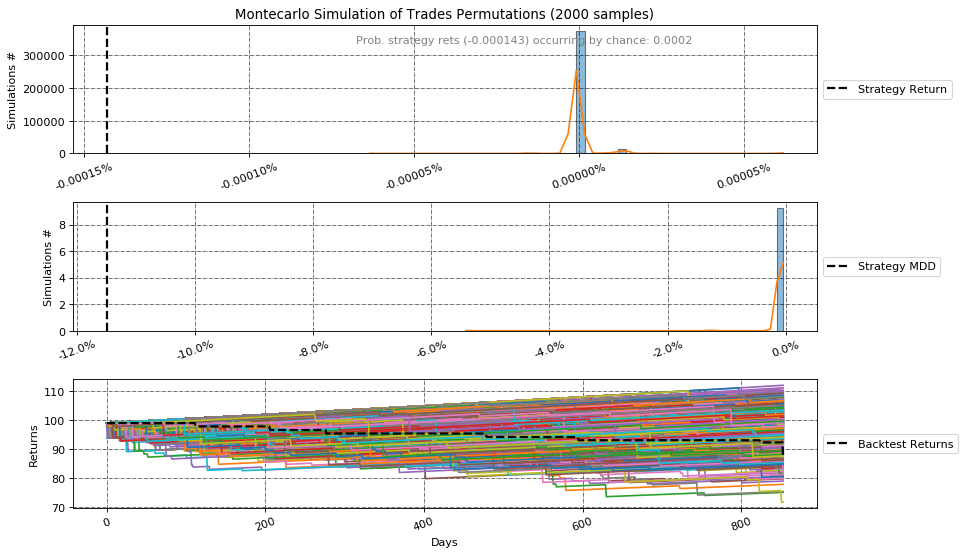

In [19]:
bs,bmp=b.bootstrapAnalysis(r.copy(),N=2000,bins=50,conf_lev=0.99,log_rets=True)


### Stop loss and Profit target optimization

In [20]:
#Stop loss and Profit target optimization
#good winners are far right of the vertical axis have MAEs less than 0.1 
#good losers are close to the left of the vertical axis have MAEs greater than 0.1
df=signalsfarm.getMAEstats(r.copy(),b.trades.copy())

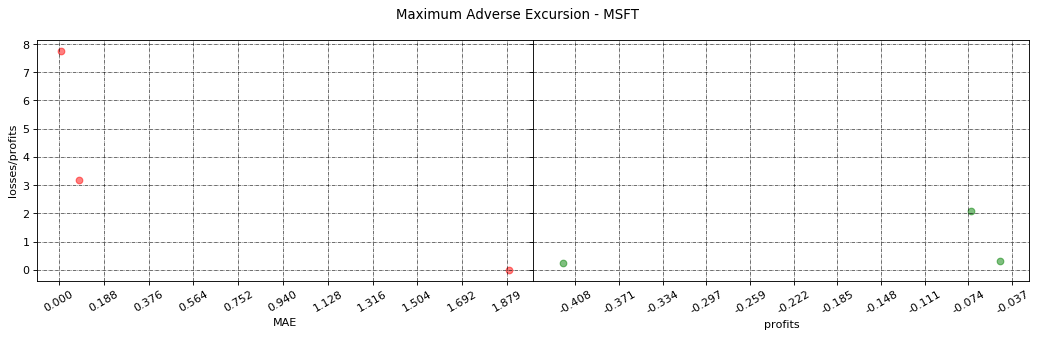

In [21]:
#Stop Loss
for sec in tickers:
    signalsfarm.plotMAEStats(df,sec,'MAE',(16,4))

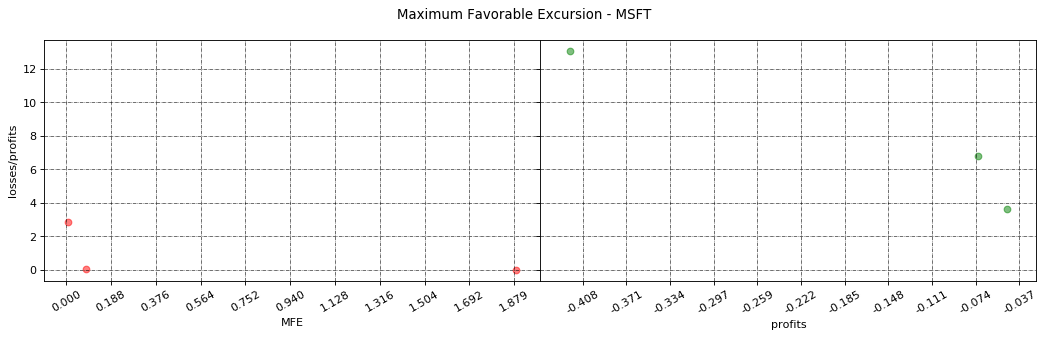

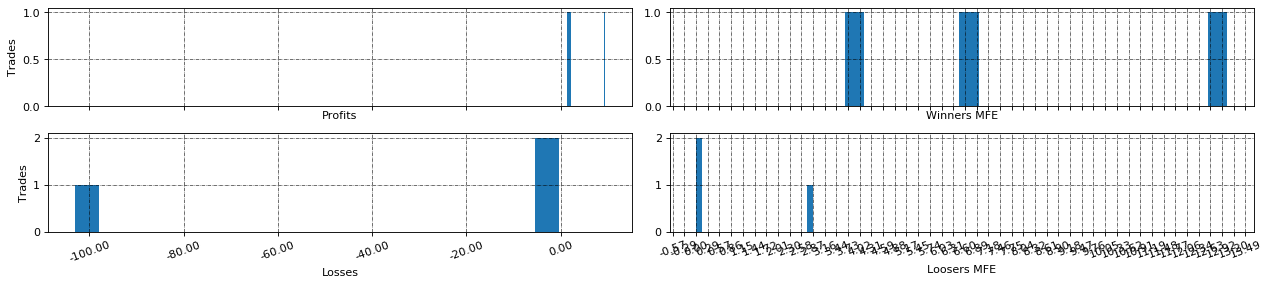

In [22]:
#Profit Targets
for sec in tickers:
    signalsfarm.plotMAEStats(df,sec,'MFE',(16,4))

### Optimization of parameters

In [12]:
#Optimizing parameters and Testing the strategy over different times and markets
t=bt.Tester(b.dt_start,b.dt_end,tickers,'SPY',data)
#Define the grid for parameters search (min,max,step)
grid = ((30, 90, 5),(5, 40, 5))
params=[40,10]
#{'OPTM':'SINGLE','OPMS':'Max Drawdown %'}
#{'OPTM':'RATIO','OPMS1':'Profits','OPMS2':'Max Drawdown %'}
lbls=['MAWin_Slow','MAWin_Fast']

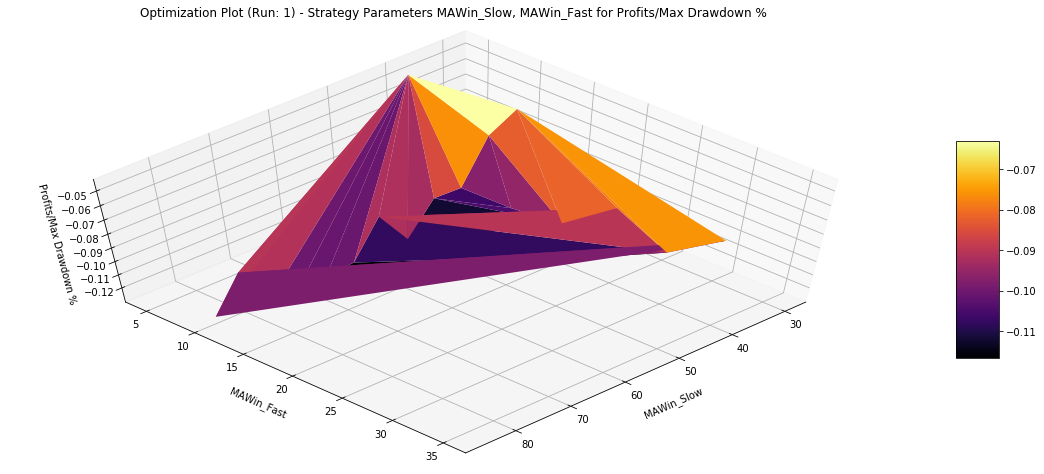

In [13]:
#OPTIMIZATION of parameters for Profits/MDD
stat_params['OPTM']='RATIO'
stat_params['OPMS1']='Profits'
stat_params['OPMS2']='Max Drawdown %'
lblm=stat_params['OPMS1']+'/'+stat_params['OPMS2']
ret1,elab1=t.optimizer(setupData,logic,grid,params,
                       stat_params=stat_params,
                       init_params=init_params,
                       algo_params=algo_params,W=4)
t.plotOptimization(elab1,lbl='1',measure=lblm,labels=lbls,angle=45)

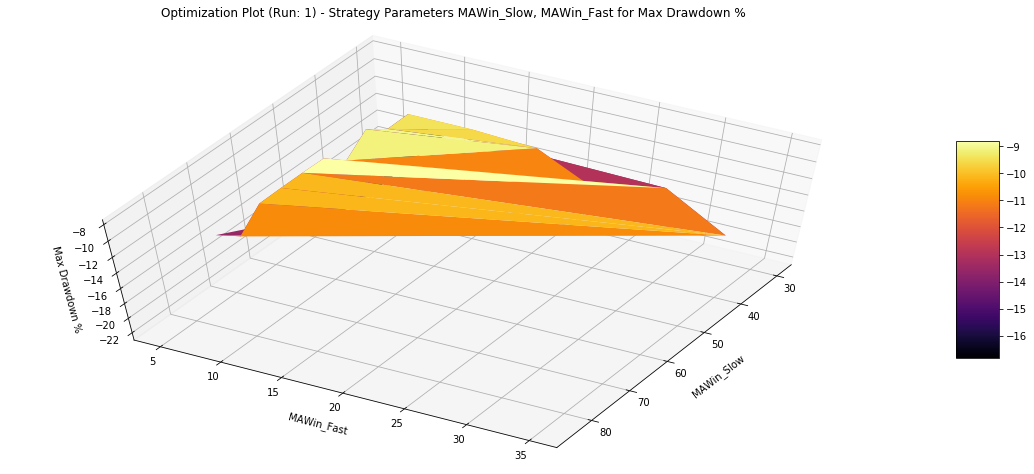

In [14]:
#OPTIMIZATION of parameters for MDD
stat_params['OPTM']='SINGLE'
stat_params['OPMS']='Max Drawdown %'
lblm=stat_params['OPMS']
ret2,elab2=t.optimizer(setupData,logic,grid,params,
                       stat_params=stat_params,
                       init_params=init_params,
                       algo_params=algo_params,W=4)
t.plotOptimization(elab2,lbl='1',measure=lblm,labels=lbls,angle=30)

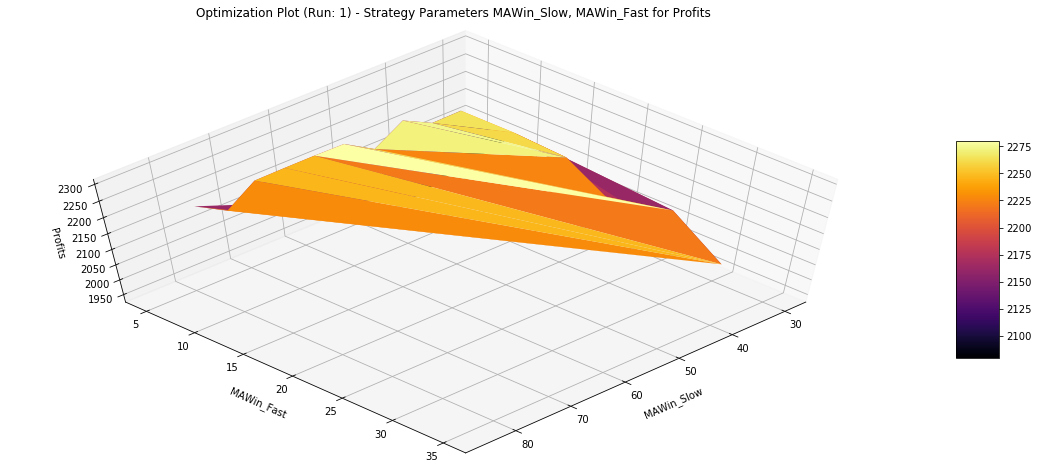

In [15]:
#OPTIMIZATION of parameters for profits
stat_params['OPTM']='SINGLE'
stat_params['OPMS']='Profits'
lblm=stat_params['OPMS']
ret3,elab3=t.optimizer(setupData,logic,grid,params,
                       stat_params=stat_params,
                       init_params=init_params,
                       algo_params=algo_params,W=4)
t.plotOptimization(elab3,lbl='1',measure=lblm,labels=lbls)


In [16]:
#Optimizing parameters and Testing the strategy over different times and markets
t=bt.Tester(b.dt_start,b.dt_end,tickers,'SPY',data)
grid = ((30, 90, 5),(5, 40, 5))
params=[85,5]
lbls=['MAWin_Long','MAWin_Short']

In [17]:
#BACKTESTING - WalkAway style
r1,h1=t.anchoredWalkAwayBT(setupData, logic,grid,params,
                            n_bt=2,pct_oos=0.15,optm=False,
                           stat_params=stat_params,
                           init_params=init_params,
                           algo_params=algo_params)
r1[0].T    

2006-12-29 2007-12-27  \
Str. Rets                                          -0.026407   
Mkt Rets                                            0.204622   
Avg Daily Rets                                     -0.000073   
Avd Daily Vol                                       0.000001   
Ann.ed Returns                                     -0.005056   
Ann.ed Vol                                          1.572280   
Sharpe Ratio                                       -1.106821   
t-stat                                             -1.330234   
Pvalue                                              0.721027   
Adj Pvalue                                          1.000000   
Sortino Ratio                                      -1.111361   
Omega Ratio                                         0.862388   
Inform. Ratio                                      -1.007532   
Skewness                                          -13.704224   
Kurtosis                                          189.180883   
30d HVaR95                                          0.000000   
30d adj VaR95                                       0.000000   
MDD Duration                                      363.000000   
Max Drawdown %                                     -2.640688   
Profits                                          2433.982800   
Geom.Rets %     6179289479097365725331368925376544768.000000   
Total trades                                        1.000000   
Wins %                                              0.000000   
Average Win                                              NaN   
Average Loss                                       -7.210000   
Max Win                                                  NaN   
Max Loss                                           -7.210000   
Max Cons. Wins                                      0.000000   
Max Cons. Loss                                      1.000000   
Avg Win Durat                                            NaN   
Avg Loss Durat                                    149.000000   
Payoff (x:1)                                             NaN   
Profit Factor                                       0.000000   
Expectancy                                               NaN   
Exp.Opp.ty                                               NaN   
S.Quality                                                NaN   
Acorr(1)                                                 NaN   
Avg Trade                                          33.008600   
Kelly %                                                  NaN   

                                         2006-12-29 2008-12-24  
Str. Rets                                            -0.114695  
Mkt Rets                                             -0.358004  
Avg Daily Rets                                       -0.000165  
Avd Daily Vol                                         0.000005  
Ann.ed Returns                                       -0.005728  
Ann.ed Vol                                            3.371535  
Sharpe Ratio                                         -1.205403  
t-stat                                               -2.047384  
Pvalue                                                0.907535  
Adj Pvalue                                            1.000000  
Sortino Ratio                                        -1.209870  
Omega Ratio                                           0.379125  
Inform. Ratio                                         0.287552  
Skewness                                            -18.834433  
Kurtosis                                            414.322891  
30d HVaR95                                            0.000000  
30d adj VaR95                                         0.000000  
MDD Duration                                        726.000000  
Max Drawdown %                                      -11.469484  
Profits                                            2213.262900  
Geom.Rets %     100828716294930585809167418383398862848.000000  
Total trades                                    

### BACKTESTING

In [18]:
#BACKTESTING - WalkAway style
stat_params['OPTM']='SINGLE'
stat_params['OPMS']='Profits'
lblm=stat_params['OPMS']
r1,h1=t.anchoredWalkAwayBT(setupData, logic,grid,params,
                           n_bt=2,pct_oos=0.15,optm=True,
                          stat_params=stat_params,
                           init_params=init_params,
                       algo_params=algo_params,W=4)
r1[0].T    

Maximum at:  35.0  Corresponding to:  2434.4589
Maximum at:  80.0  Corresponding to:  2433.99
Maximum at:  15.0  Corresponding to:  2357.7086999999997
Maximum at:  65.0  Corresponding to:  2309.1794000000004


2006-12-29 2007-12-27  \
Str. Rets                                             -0.026243   
Mkt Rets                                               0.204622   
Avg Daily Rets                                        -0.000073   
Avd Daily Vol                                          0.000001   
Ann.ed Returns                                        -0.005024   
Ann.ed Vol                                             1.563691   
Sharpe Ratio                                          -1.105522   
t-stat                                                -1.328672   
Pvalue                                                 0.720900   
Adj Pvalue                                             1.000000   
Sortino Ratio                                         -1.110052   
Omega Ratio                                            0.867855   
Inform. Ratio                                         -1.009432   
Skewness                                             -13.736147   
Kurtosis                                             190.325874   
30d HVaR95                                             0.000000   
30d adj VaR95                                          0.000000   
MDD Duration                                         363.000000   
Max Drawdown %                                        -2.624268   
Profits                                             2434.393300   
Geom.Rets %     1521703701268111915375114455690782965760.000000   
Total trades                                           1.000000   
Wins %                                                 0.000000   
Average Win                                                 NaN   
Average Loss                                          -7.649900   
Max Win                                                     NaN   
Max Loss                                              -7.649900   
Max Cons. Wins                                         0.000000   
Max Cons. Loss                                         1.000000   
Avg Win Durat                                               NaN   
Avg Loss Durat                                       143.000000   
Payoff (x:1)                                                NaN   
Profit Factor                                          0.000000   
Expectancy                                                  NaN   
Exp.Opp.ty                                                  NaN   
S.Quality                                                   NaN   
Acorr(1)                                                    NaN   
Avg Trade                                             32.803350   
Kelly %                                                     NaN   

                   2007-12-27 2008-05-02  \
Str. Rets                       0.000000   
Mkt Rets                       -0.187100   
Avg Daily Rets                  0.000000   
Avd Daily Vol                   0.000000   
Ann.ed Returns                  0.000000   
Ann.ed Vol                      0.000000   
Sharpe Ratio    74079203087145584.000000   
t-stat          52795999511875280.000000   
Pvalue                               NaN   
Adj Pvalue                           NaN   
Sortino Ratio                        inf   
Omega Ratio                         -inf   
Inform. Ratio                   1.649458   
Skewness                        0.000000   
Kurtosis                        0.000000   
30d HVaR95                      0.000000   
30d adj VaR95                   0.000000   
MDD Duration                    0.000000   
Max Drawdown %                  0.000000   
Profits                      2500.000000   
Geom.Rets %                     0.000000   
Total trades                    0.000000   
Wins %                          0.000000   
Average Win                          NaN   
Average Loss                         NaN   
Max Win                              NaN   
Max Loss                             NaN   
Max Cons. Wins                       NaN   
Max Cons. Loss                       NaN   
Avg Win Durat                        NaN 

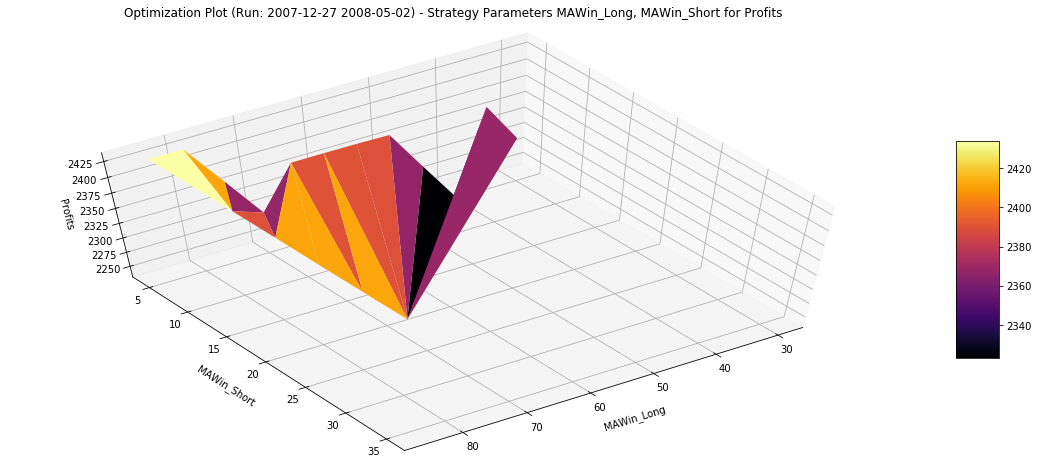

In [19]:
if len(r1[1]):
    for k in r1[1].keys():
        t.plotOptimization(r1[1][k],lbl=r1[0].T.columns[int(k)],measure=lblm,labels=lbls,angle=55)


In [20]:
#BACKTESTING - Cross-validation style
stat_params['OPTM']='SINGLE'
stat_params['OPMS']='Profits'
lblm=stat_params['OPMS']
r2,h2=t.crossValidationBT(setupData, logic,grid,params,
                          n_bt=2,optm=True,
                          stat_params=stat_params,
                          init_params=init_params,
                          algo_params=algo_params,W=4)
r2[0].T

Maximum at:  5.0  Corresponding to:  2442.3399999999997
Maximum at:  85.0  Corresponding to:  2442.3693999999996
Maximum at:  25.0  Corresponding to:  2500.0
Maximum at:  65.0  Corresponding to:  2415.6646


2006-12-29 2008-02-28                   2008-02-28 2009-04-29  \
Str. Rets                  -0.023075                               -0.038190   
Mkt Rets                   -0.064635                               -0.274973   
Avg Daily Rets             -0.000054                               -0.000091   
Avd Daily Vol               0.000001                                0.000001   
Ann.ed Returns             -0.003208                               -0.005346   
Ann.ed Vol                  1.259431                                1.741719   
Sharpe Ratio               -1.008208                               -1.253132   
t-stat                     -1.312393                               -1.631212   
Pvalue                      0.761395                                0.789778   
Adj Pvalue                  1.000000                                1.000000   
Sortino Ratio              -1.011762                               -1.258879   
Omega Ratio                 1.160333                                0.694288   
Inform. Ratio               0.060969                                0.223713   
Skewness                  -14.563929                              -12.504768   
Kurtosis                  211.135623                              160.703176   
30d HVaR95                  0.000000                                0.000000   
30d adj VaR95               0.000000                                0.000000   
MDD Duration              426.000000                              425.958333   
Max Drawdown %             -2.307532                               -3.818968   
Profits                  2442.311700                             2404.525800   
Geom.Rets %               -99.999947  5955567936570497345869924270080.000000   
Total trades                1.000000                                2.000000   
Wins %                    100.000000                                0.000000   
Average Win                 1.140000                                     NaN   
Average Loss                     NaN                               -6.067050   
Max Win                     1.140000                                     NaN   
Max Loss                         NaN                              -11.939900   
Max Cons. Wins              1.000000                                0.000000   
Max Cons. Loss              0.000000                                2.000000   
Avg Win Durat             212.000000                                     NaN   
Avg Loss Durat                   NaN                              126.500000   
Payoff (x:1)                     NaN                                     NaN   
Profit Factor               0.000000                                0.000000   
Expectancy                       NaN                                     NaN   
Exp.Opp.ty                       NaN                                     NaN   
S.Quality                        NaN                                     NaN   
Acorr(1)                         NaN                                     NaN   
Avg Trade                  28.844150                               30.846575   
Kelly %                          NaN                                     NaN   

                   2008-02-28 2009-04-29  \
Str. Rets                       0.000000   
Mkt Rets                       -0.274973   
Avg Daily Rets                  0.000000   
Avd Daily Vol                   0.000000   
Ann.ed Returns                  0.000000   
Ann.ed Vol                      0.000000   
Sharpe Ratio    37141572971120056.000000   
t-stat          48347493043392296.000000   
Pvalue                          0.000000   
Adj Pvalue                      0.000000   
Sortino Ratio                        inf   
Omega Ratio                         -inf   
Inform. Ratio                   0.267457   
Skewness                        0.000000   
Kurtosis                        0.000000   
30d HVaR95                      0.000000   
30d adj VaR95                   0.000000   
MDD Duration          

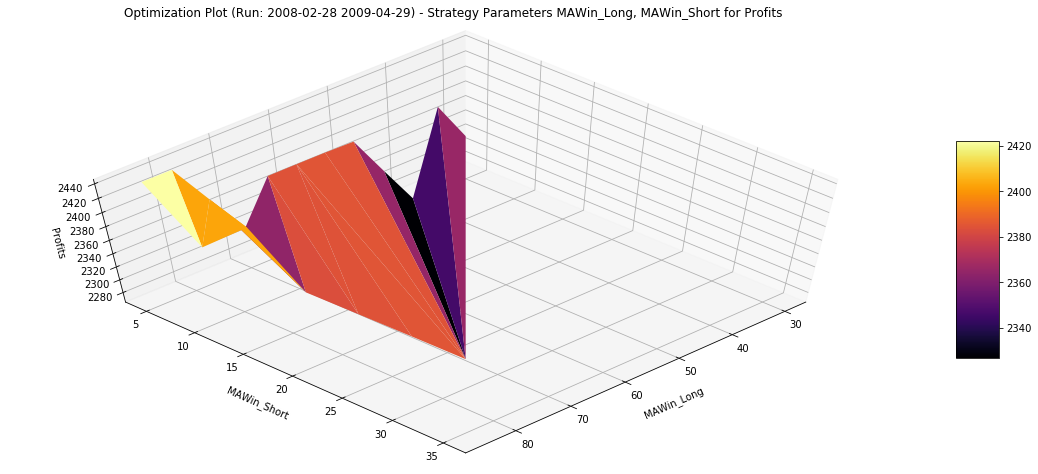

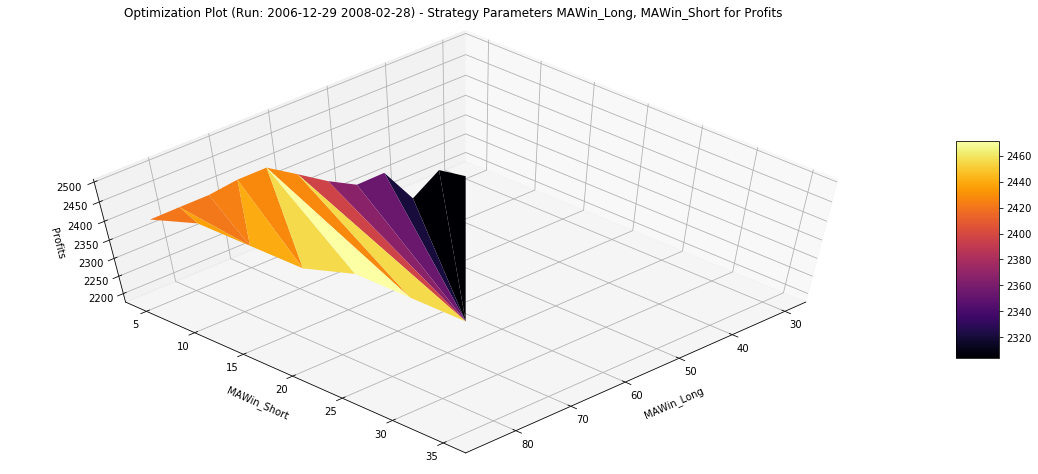

In [21]:
if len(r2[1]):
    for k in r2[1].keys():
        t.plotOptimization(r2[1][k],lbl=r2[0].T.columns[int(k)],measure=lblm,labels=lbls)


In [22]:
#BACKTESTING - WalkAway style
r3,h3=t.walkAwayBT(setupData, logic,grid,params,
                   n_bt=2,pct_oos=0.1,optm=False,
                   stat_params=stat_params,
                   init_params=init_params,
                   algo_params=algo_params)
r3[0].T    

2006-12-29 2008-01-17  \
Str. Rets                           -0.025054   
Mkt Rets                             0.108841   
Avg Daily Rets                      -0.000065   
Avd Daily Vol                        0.000001   
Ann.ed Returns                      -0.004286   
Ann.ed Vol                           1.443772   
Sharpe Ratio                        -1.073729   
t-stat                              -1.327165   
Pvalue                               0.737246   
Adj Pvalue                           1.000000   
Sortino Ratio                       -1.077917   
Omega Ratio                          0.962225   
Inform. Ratio                       -0.607684   
Skewness                           -13.916665   
Kurtosis                           193.565636   
30d HVaR95                           0.000000   
30d adj VaR95                        0.000000   
MDD Duration                       384.000000   
Max Drawdown %                      -2.505352   
Profits                           2437.366200   
Geom.Rets %     2661305423435659739136.000000   
Total trades                         1.000000   
Wins %                               0.000000   
Average Win                               NaN   
Average Loss                        -3.830000   
Max Win                                   NaN   
Max Loss                            -3.830000   
Max Cons. Wins                       0.000000   
Max Cons. Loss                       1.000000   
Avg Win Durat                             NaN   
Avg Loss Durat                     170.000000   
Payoff (x:1)                              NaN   
Profit Factor                        0.000000   
Expectancy                                NaN   
Exp.Opp.ty                                NaN   
S.Quality                                 NaN   
Acorr(1)                                  NaN   
Avg Trade                           31.316900   
Kelly %                                   NaN   

                                           2008-01-17 2009-02-04  
Str. Rets                                              -0.074713  
Mkt Rets                                               -0.437330  
Avg Daily Rets                                         -0.000200  
Avd Daily Vol                                           0.000004  
Ann.ed Returns                                         -0.013074  
Ann.ed Vol                                              3.108358  
Sharpe Ratio                                           -1.587057  
t-stat                                                 -1.961655  
Pvalue                                                  0.781450  
Adj Pvalue                                              1.000000  
Sortino Ratio                                          -1.597367  
Omega Ratio                                             0.312731  
Inform. Ratio                                           0.728898  
Skewness                                              -12.185929  
Kurtosis                                              170.527582  
30d HVaR95                                              0.000000  
30d adj VaR95                                           0.000000  
MDD Duration                                          384.000000  
Max Drawdown %                                         -7.471292  
Profits                                              2313.217700  
Geom.Rets %     12843336050620941930796801072310165438464.000000  
Total trades                                            4.000000  
Wins %                                                 25.000000  
Average Win                                             1.295400  
Average Loss                                          -15.663333  
Max Win                                                 1.295400  
Max Loss                                              -46.060000  
Max Cons. Wins                                          1.000000  
Max Cons. Loss                                          2.000000  
Avg Win Durat                                        